<a href="https://colab.research.google.com/github/francisbonheur/alyra_projet_deep_learning/blob/main/violence_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image as IPImage, display
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import image_dataset_from_directory


In [3]:
print("📥 Chargement du modèle MobileNetV2 avec Keras...")
print("   (Cela peut prendre quelques secondes la première fois)\n")

# Charger MobileNetV2 pré-entraîné sans le classifier (include_top=False)
# On va ajouter notre propre classifier pour les fleurs
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclure la couche de classification ImageNet
    weights='imagenet',  # Charger les poids pré-entraînés sur ImageNet
    pooling='avg'  # Global Average Pooling à la fin
)

print("✅ Modèle MobileNetV2 chargé !\n")

# Afficher la structure du modèle
print("📋 Structure du modèle MobileNetV2 :")
print(f"  - Architecture   : MobileNetV2")
print(f"  - Input shape    : (224, 224, 3)")
print(f"  - Poids          : ImageNet (1000 classes)")
print(f"  - Output shape   : {base_model.output_shape}")
print(f"  - Nombre de couches : {len(base_model.layers)}")

# Compter les paramètres
total_params = base_model.count_params()
print(f"\n  - Nombre total de paramètres : {total_params:,}")
print(f"  - Taille en mémoire (approx.) : {total_params * 4 / (1024**2):.1f} MB")

print("\n💡 Ce modèle a déjà été entraîné sur 1.4 million d'images !")
print("   Nous allons maintenant l'adapter à notre tâche de classification de fleurs.")

📥 Chargement du modèle MobileNetV2 avec Keras...
   (Cela peut prendre quelques secondes la première fois)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Modèle MobileNetV2 chargé !

📋 Structure du modèle MobileNetV2 :
  - Architecture   : MobileNetV2
  - Input shape    : (224, 224, 3)
  - Poids          : ImageNet (1000 classes)
  - Output shape   : (None, 1280)
  - Nombre de couches : 155

  - Nombre total de paramètres : 2,257,984
  - Taille en mémoire (approx.) : 8.6 MB

💡 Ce modèle a déjà été entraîné sur 1.4 million d'images !
   Nous allons maintenant l'adapter à notre tâche de classification de fleurs.


In [4]:
print("🔍 Aperçu des couches de MobileNetV2\n")
print("="*80)

# Fonction helper pour obtenir l'output shape
def get_output_shape(layer):
    try:
        if hasattr(layer, 'output_shape'):
            return str(layer.output_shape)
        elif hasattr(layer, 'output'):
            return str(layer.output.shape)
        else:
            return "N/A"
    except:
        return "N/A"

# Afficher les 10 premières et 10 dernières couches
print("\n📌 Premières couches (extraction de features bas niveau) :")
for i, layer in enumerate(base_model.layers[:10]):
    output_shape = get_output_shape(layer)
    print(f"  {i+1:3d}. {layer.name:40s} | Output: {output_shape:30s} | Trainable: {layer.trainable}")

print("\n      ...")

print("\n📌 Dernières couches (features haut niveau) :")
for i, layer in enumerate(base_model.layers[-10:], start=len(base_model.layers)-10):
    output_shape = get_output_shape(layer)
    print(f"  {i+1:3d}. {layer.name:40s} | Output: {output_shape:30s} | Trainable: {layer.trainable}")

print("\n" + "="*80)

🔍 Aperçu des couches de MobileNetV2


📌 Premières couches (extraction de features bas niveau) :
    1. input_layer                              | Output: (None, 224, 224, 3)            | Trainable: True
    2. Conv1                                    | Output: (None, 112, 112, 32)           | Trainable: True
    3. bn_Conv1                                 | Output: (None, 112, 112, 32)           | Trainable: True
    4. Conv1_relu                               | Output: (None, 112, 112, 32)           | Trainable: True
    5. expanded_conv_depthwise                  | Output: (None, 112, 112, 32)           | Trainable: True
    6. expanded_conv_depthwise_BN               | Output: (None, 112, 112, 32)           | Trainable: True
    7. expanded_conv_depthwise_relu             | Output: (None, 112, 112, 32)           | Trainable: True
    8. expanded_conv_project                    | Output: (None, 112, 112, 16)           | Trainable: True
    9. expanded_conv_project_BN                 

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdulmananraja/real-life-violence-situations")

data_dir = path + "/new_violence"

print("Path to dataset files:", data_dir)


100%|██████████| 225M/225M [00:02<00:00, 108MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdulmananraja/real-life-violence-situations/versions/1/new_violence


In [6]:
print("🔧 Préparation des datasets...\n")

# Paramètres
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
SEED = 42

# IMPORTANT : Spécifier explicitement les classes valides pour éviter d'inclure des dossiers non-désirés
valid_class_names = ['non_violence', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Créer le dataset d'entraînement avec filtrage des classes
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred'
)

# Créer le dataset de validation avec les mêmes classes
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred'
)

# Obtenir les noms de classes (devrait être les 5 classes de fleurs)
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"✅ Datasets créés !\n")
print(f"📊 Information sur les datasets :")
print(f"  - Classes        : {class_names}")
print(f"  - Nombre de classes : {num_classes}")

# Vérification de sécurité
if num_classes != 2:
    print(f"\n⚠️  ERREUR : {num_classes} classes détectées au lieu de 2 !")
    print(f"   Classes trouvées : {class_names}")
else:
    print(f"  - ✅ Nombre de classes correct : 2")

print(f"\n  - Train batches  : {len(train_ds)}")
print(f"  - Val batches    : {len(val_ds)}")
print(f"  - Batch size     : {BATCH_SIZE}")
print(f"  - Image size     : {IMG_SIZE}")
print(f"\n  - Train samples  : ~{len(train_ds) * BATCH_SIZE}")
print(f"  - Val samples    : ~{len(val_ds) * BATCH_SIZE}")

🔧 Préparation des datasets...

Found 11073 files belonging to 2 classes.
Using 8859 files for training.
Found 11073 files belonging to 2 classes.
Using 2214 files for validation.
✅ Datasets créés !

📊 Information sur les datasets :
  - Classes        : ['non_violence', 'violence']
  - Nombre de classes : 2
  - ✅ Nombre de classes correct : 2

  - Train batches  : 277
  - Val batches    : 70
  - Batch size     : 32
  - Image size     : (224, 224)

  - Train samples  : ~8864
  - Val samples    : ~2240


In [7]:
print("🎨 Configuration du prétraitement et de la data augmentation...\n")

# Créer une fonction de prétraitement pour MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Créer un modèle d'augmentation de données plus agressif
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),  # Rotation jusqu'à 30%
    layers.RandomZoom(0.2),
], name="data_augmentation")

# Fonction pour appliquer le prétraitement
def prepare_dataset(ds, augment=False, shuffle=True):
    # Normalisation MobileNetV2
    normalization = lambda x, y: (preprocess_input(x), y)
    ds = ds.map(normalization, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmentation (seulement pour le train)
    if augment:
        augmentation = lambda x, y: (data_augmentation(x, training=True), y)
        ds = ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle pour le training
    if shuffle:
        ds = ds.shuffle(1000)

    # Optimisation des performances
    ds = ds.cache()  # Cache en mémoire
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch pour accélérer

    return ds

# Appliquer le prétraitement
train_ds_prepared = prepare_dataset(train_ds, augment=True, shuffle=True)
val_ds_prepared = prepare_dataset(val_ds, augment=False, shuffle=False)

print("✅ Prétraitement et augmentation configurés !\n")
print("📝 Transformations appliquées :")
print("  - Train : Normalisation + Augmentation (flip, rotation, zoom, contrast, translation, brightness)")
print("  - Val   : Normalisation seulement")
print("\n  - Shuffle, cache et prefetch activés pour les performances")

🎨 Configuration du prétraitement et de la data augmentation...

✅ Prétraitement et augmentation configurés !

📝 Transformations appliquées :
  - Train : Normalisation + Augmentation (flip, rotation, zoom, contrast, translation, brightness)
  - Val   : Normalisation seulement

  - Shuffle, cache et prefetch activés pour les performances


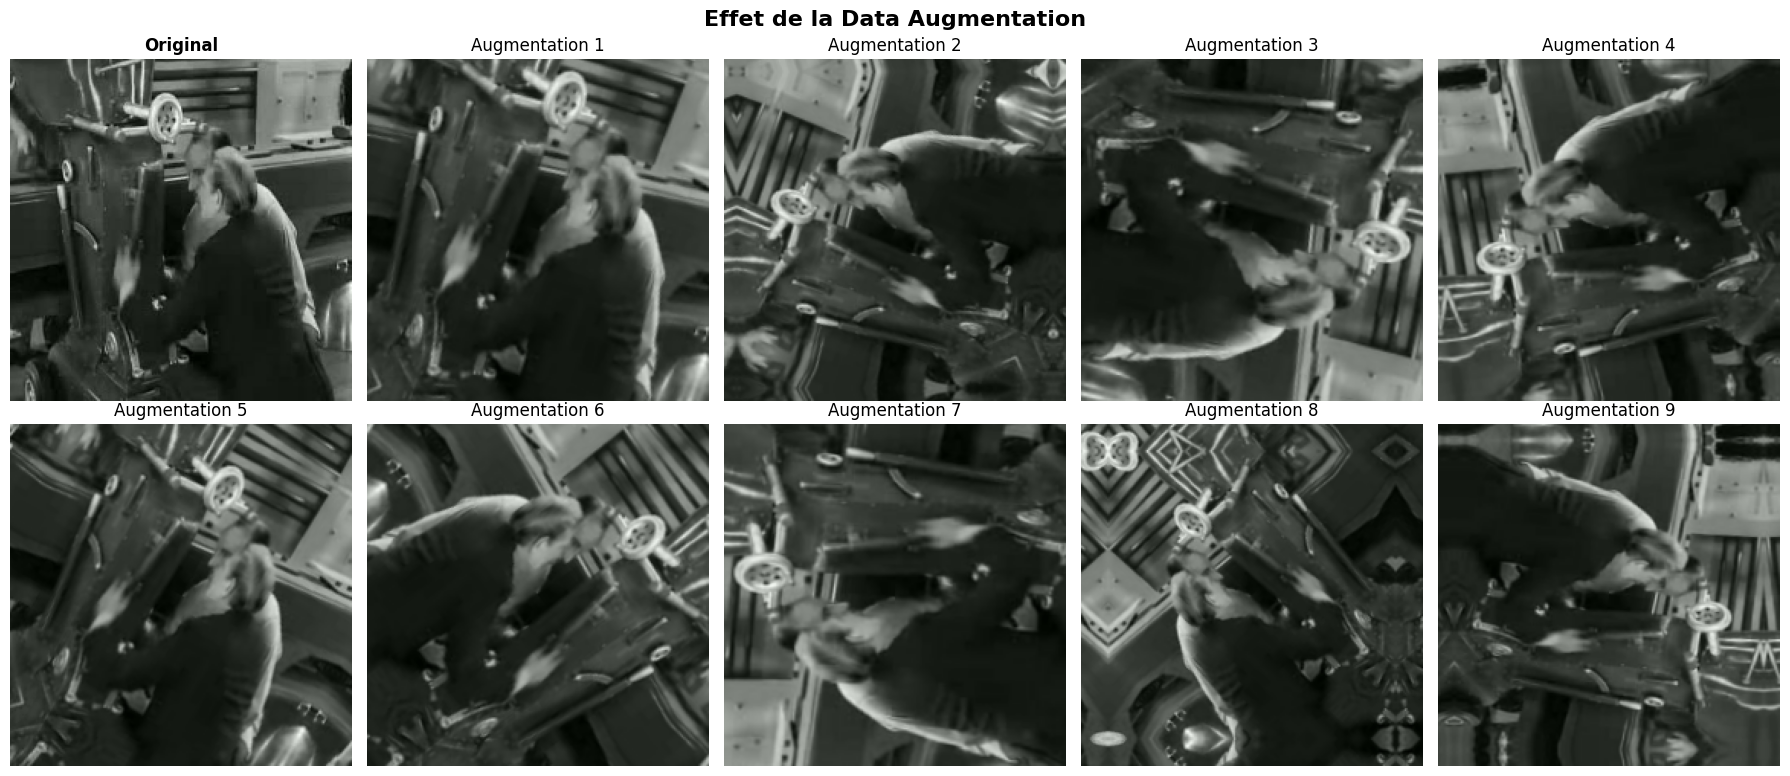


💡 L'augmentation crée des variations réalistes pour améliorer la robustesse du modèle.


In [8]:
# Prendre un batch d'exemples
for images, labels in train_ds.take(1):
    # Prendre la première image
    sample_image = images[0].numpy().astype("uint8")

    # Appliquer l'augmentation 9 fois
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.flatten()

    # Image originale
    axes[0].imshow(sample_image)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Images augmentées
    for i in range(1, 10):
        augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
        axes[i].imshow(augmented[0].numpy().astype("uint8"))
        axes[i].set_title(f'Augmentation {i}', fontsize=12)
        axes[i].axis('off')

    plt.suptitle('Effet de la Data Augmentation', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    break

print("\n💡 L'augmentation crée des variations réalistes pour améliorer la robustesse du modèle.")

In [9]:
print("🧊 Construction du modèle Feature Extraction (OPTIMISÉ)...\n")

# Geler le modèle de base
base_model.trainable = False

print(f"✅ Modèle de base gelé")
print(f"   {len(base_model.layers)} couches non-entraînables\n")

# Architecture OPTIMALE pour ce dataset
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# Classifier avec régularisation modérée
x = layers.Dropout(0.3)(x)  # Dropout modéré
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_frozen = keras.Model(inputs, outputs, name='MobileNetV2_Frozen')

# Compiler avec LR optimal
model_frozen.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # LR standard
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle compilé !\n")

print("📊 Architecture :")
print("  Input(224,224,3) → MobileNetV2 → Dropout(0.3) → Dense(256,relu) → Dropout(0.3) → Dense(2,sigmoid)")

trainable = sum([tf.size(w).numpy() for w in model_frozen.trainable_weights])
non_trainable = sum([tf.size(w).numpy() for w in model_frozen.non_trainable_weights])
print(f"\n  - Paramètres entraînables    : {trainable:,}")
print(f"  - Paramètres non-entraînables: {non_trainable:,}")
print(f"  - Total                      : {trainable + non_trainable:,}")

print("\n💡 Configuration optimale :")
print("  - Learning rate : 0.001 (standard)")
print("  - Dropout       : 0.3 (modéré)")
print("  - Dense cachée  : 256 neurones")
print("  - L2 reg        : 0.01")

🧊 Construction du modèle Feature Extraction (OPTIMISÉ)...

✅ Modèle de base gelé
   155 couches non-entraînables

✅ Modèle compilé !

📊 Architecture :
  Input(224,224,3) → MobileNetV2 → Dropout(0.3) → Dense(256,relu) → Dropout(0.3) → Dense(2,sigmoid)

  - Paramètres entraînables    : 328,193
  - Paramètres non-entraînables: 2,257,984
  - Total                      : 2,586,177

💡 Configuration optimale :
  - Learning rate : 0.001 (standard)
  - Dropout       : 0.3 (modéré)
  - Dense cachée  : 256 neurones
  - L2 reg        : 0.01


In [10]:
print("🚀 Entraînement du modèle frozen...\n")

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Patience raisonnable
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model_frozen.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

EPOCHS_FROZEN = 30

print(f"Configuration :")
print(f"  - Epochs max : {EPOCHS_FROZEN}")
print(f"  - Patience   : 10 epochs")
print(f"  - LR initial : 0.001")
print(f"  - LR min     : 1e-7\n")

history_frozen = model_frozen.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=EPOCHS_FROZEN,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("\n✅ Entraînement frozen terminé !")
print(f"   Epochs effectués : {len(history_frozen.history['loss'])}")

best_val_acc = max(history_frozen.history['val_accuracy'])
best_epoch = history_frozen.history['val_accuracy'].index(best_val_acc) + 1
print(f"   Meilleure val_accuracy : {best_val_acc*100:.2f}% (epoch {best_epoch})")

if best_val_acc < 0.70:
    print(f"\n⚠️  Accuracy de {best_val_acc*100:.1f}% est en dessous de 70%")
    print("   Le modèle pourrait bénéficier de plus d'entraînement.")
elif best_val_acc < 0.80:
    print(f"\n✅ Bon résultat : {best_val_acc*100:.1f}%")
else:
    print(f"\n🎯 Excellent ! Accuracy de {best_val_acc*100:.1f}%")

🚀 Entraînement du modèle frozen...

Configuration :
  - Epochs max : 30
  - Patience   : 10 epochs
  - LR initial : 0.001
  - LR min     : 1e-7

Epoch 1/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 136s 137ms/step - accuracy: 0.7639 - loss: 2.7532 - val_accuracy: 0.8780 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 2/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8288 - loss: 0.7054 - val_accuracy: 0.8776 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 3/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8356 - loss: 0.5269 - val_accuracy: 0.8731 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 4/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8518 - loss: 0.4873 - val_accuracy: 0.8803 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 5/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8487 - loss: 0.4742 - val_accuracy: 0.8826 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 6/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8627 - loss: 0.

In [11]:
print("🔍 Diagnostic du modèle frozen\n")
print("="*80)

# Obtenir quelques prédictions sur le validation set
for images, labels in val_ds_prepared.take(1):
    predictions = model_frozen.predict(images[:5], verbose=0)

    print("\n📊 Échantillon de prédictions :")
    print("-"*80)

    for i in range(5):
        true_label = np.argmax(labels[i])
        pred_label = np.argmax(predictions[i])
        confidence = predictions[i][pred_label]

        status = "✅" if true_label == pred_label else "❌"
        print(f"{status} Image {i+1}: Vrai={class_names[true_label]:12s} | Prédit={class_names[pred_label]:12s} | Conf={confidence*100:5.1f}%")

print("\n" + "="*80)
print("\n💡 Si beaucoup de prédictions sont incorrectes, vérifiez :")
print("   1. Le preprocessing est correct (preprocess_input pour MobileNetV2)")
print("   2. Le modèle a été entraîné suffisamment longtemps")
print("   3. Le learning rate n'est pas trop faible")
print("\n⚠️  Si l'accuracy frozen est < 70%, le fine-tuning ne sera pas efficace !")

🔍 Diagnostic du modèle frozen


📊 Échantillon de prédictions :
--------------------------------------------------------------------------------
✅ Image 1: Vrai=non_violence | Prédit=non_violence | Conf=  1.1%
✅ Image 2: Vrai=non_violence | Prédit=non_violence | Conf= 99.8%
✅ Image 3: Vrai=non_violence | Prédit=non_violence | Conf=  0.2%
✅ Image 4: Vrai=non_violence | Prédit=non_violence | Conf= 85.5%
✅ Image 5: Vrai=non_violence | Prédit=non_violence | Conf=  1.5%


💡 Si beaucoup de prédictions sont incorrectes, vérifiez :
   1. Le preprocessing est correct (preprocess_input pour MobileNetV2)
   2. Le modèle a été entraîné suffisamment longtemps
   3. Le learning rate n'est pas trop faible

⚠️  Si l'accuracy frozen est < 70%, le fine-tuning ne sera pas efficace !


📊 Évaluation du modèle frozen sur validation...

Résultats :
  - Loss                : 0.3050
  - Accuracy            : 91.33%


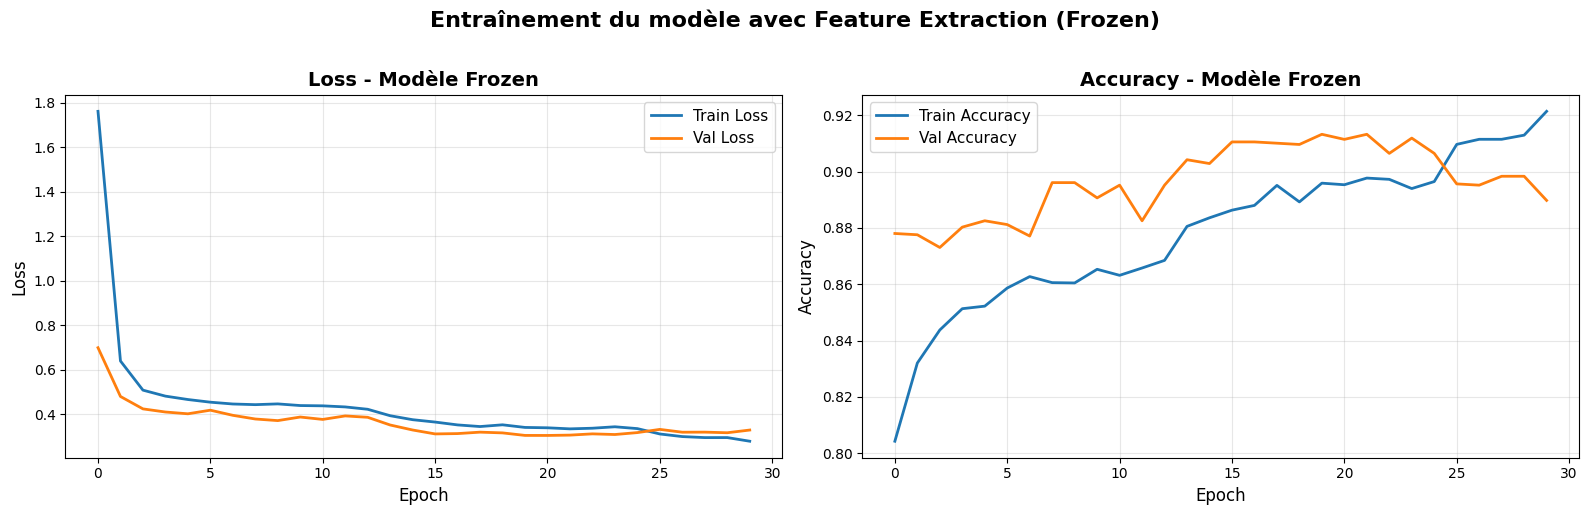


💡 Le modèle frozen donne déjà de bons résultats !
   Voyons maintenant si le fine-tuning peut améliorer les performances.


In [12]:
# Évaluation sur validation
print("📊 Évaluation du modèle frozen sur validation...\n")

results_frozen = model_frozen.evaluate(val_ds_prepared, verbose=0)

print("Résultats :")
print(f"  - Loss                : {results_frozen[0]:.4f}")
print(f"  - Accuracy            : {results_frozen[1]*100:.2f}%")

# Visualiser les courbes d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history_frozen.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_frozen.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss - Modèle Frozen', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_frozen.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_frozen.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy - Modèle Frozen', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Entraînement du modèle avec Feature Extraction (Frozen)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Le modèle frozen donne déjà de bons résultats !")
print("   Voyons maintenant si le fine-tuning peut améliorer les performances.")

In [ ]:
model_path = 'sample_data/mobilenetv2_flowers_finetuned.keras'
model_frozen.save(model_path)

print(f"✅ Modèle sauvegardé : {model_path}")
print(f"   Taille du fichier : {os.path.getsize(model_path) / (1024**2):.1f} MB")


✅ Modèle sauvegardé : mobilenetv2_flowers_finetuned.keras
   Taille du fichier : 12.9 MB
